In [4]:
import gc
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Change this for validation with 10% from train
is_valid = False

# Check directories
from pathlib import Path
path = '../input/'
modelpath = '../model/'
subpath = '../sub/'
picpath = '../pic/'
directories = [path, modelpath, subpath, picpath]
for p in directories:
    if not(Path(p).is_dir()):
        Path(p).mkdir()

def timeFeatures(df):
    # Make some new features with click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['dow']      = df['datetime'].dt.dayofweek
    df['doy']      = df["datetime"].dt.dayofyear
    # df['dteom']    = df["datetime"].dt.daysinmonth - df["datetime"].dt.day
    # df['doh']      = df['datetime'].dt.hour.astype('uint8')
    df.drop(['click_time', 'datetime'], axis=1, inplace=True)
    return df





In [4]:
def splXgb(iteration, is_valid=False):
    start_time = time.time()

    train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
    test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
    dtypes = {
            'ip'            : 'uint32',
            'app'           : 'uint16',
            'device'        : 'uint16',
            'os'            : 'uint16',
            'channel'       : 'uint16',
            'is_attributed' : 'uint8',
            'click_id'      : 'uint32'
            }
    nDimSample = 61600000

    # Read the last lines because they are more impacting in training than the starting lines
    skiprows = 0 if iteration ==0 else range(1, iteration*nDimSample)
    print(skiprows)
    train = pd.read_csv(path+"train.csv", skiprows=skiprows, nrows=nDimSample, usecols=train_columns, dtype=dtypes)
    test = pd.read_csv(path+"test_supplement.csv", usecols=test_columns, dtype=dtypes)

    print('[{}] Finished to load data'.format(time.time() - start_time))

    # Drop the IP and the columns from target
    y = train['is_attributed']
    train.drop(['is_attributed'], axis=1, inplace=True)

    # Drop IP and ID from test rows
    sub = pd.DataFrame()
    test.drop(['click_id'], axis=1, inplace=True)
    gc.collect()

    nrow_train = train.shape[0]
    merge = pd.concat([train, test])

    del train, test
    gc.collect()

    # Count the number of clicks by ip
    ip_count = merge.groupby(['ip'])['channel'].count().reset_index()
    ip_count.columns = ['ip', 'clicks_by_ip']
    merge = pd.merge(merge, ip_count, on='ip', how='left', sort=False)
    merge['clicks_by_ip'] = merge['clicks_by_ip'].astype('uint16')
    merge.drop('ip', axis=1, inplace=True)

    train = merge[:nrow_train]
    test = merge[nrow_train:]

    del test, merge
    gc.collect()

    print('[{}] Start to generate time features'.format(time.time() - start_time))

    train = timeFeatures(train)
    gc.collect()

    print('[{}] Start XGBoost Training'.format(time.time() - start_time))
    # date for filename
    from datetime import datetime as dt
    datetime = dt.now().strftime('_%Y_%m%d_%H%M_%S')
    
    # Set the params(this params from Pranav kernel) for xgboost model
    params = {'eta': 0.3,
              'tree_method': "hist",
              'grow_policy': "lossguide",
              'max_leaves': 1400,  
              'max_depth': 0, 
              'subsample': 0.9, 
              'colsample_bytree': 0.7, 
              'colsample_bylevel':0.7,
              'min_child_weight':0,
              'alpha':4,
              'objective': 'binary:logistic', 
              'scale_pos_weight':9,
              'eval_metric': 'auc', 
              'nthread':8,
              'random_state': 99, 
              'silent': True}


    if (is_valid == True):
        # Get 10% of train dataset to use as validation
        x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
        dtrain = xgb.DMatrix(x1, y1)
        dvalid = xgb.DMatrix(x2, y2)
        del x1, y1, x2, y2 
        gc.collect()
        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)
        del dvalid
    else:
        dtrain = xgb.DMatrix(train, y)
        del y
        gc.collect()
        watchlist = [(dtrain, 'train')]
        model = xgb.train(params, dtrain, 30, watchlist, maximize=True, verbose_eval=1)

    del dtrain
    gc.collect()

    print('[{}] Finish XGBoost Training'.format(time.time() - start_time))

    # Plot the feature importance from xgboost
    plot_importance(model)
    plt.gcf().savefig(picpath + 'feature_importance_splxgb' + str(iteration) + datetime + '.png')

    # Load the test for predict 
    test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)
    test = pd.merge(test, ip_count, on='ip', how='left', sort=False)
    del ip_count
    gc.collect()

    # save the train predictions
    dtraintest = xgb.DMatrix(train)
    del train
    gc.collect()
    pred = model.predict(dtraintest, ntree_limit=model.best_ntree_limit)
    del dtraintest
    gc.collect()
    subtrain = pd.DataFrame()
    subtrain['is_attributed'] = pred
    subtrainname = subpath + 'splxgb_subtrain' + str(iteration) + datetime + '.csv'
    subtrain.to_csv(subtrainname, float_format='%.8f', index=False)
    del subtrain, pred
    gc.collect()
    
    # Save the predictions
    sub['click_id'] = test['click_id'].astype('int')
    test['clicks_by_ip'] = test['clicks_by_ip'].astype('uint16')
    test = timeFeatures(test)
    test.drop(['click_id', 'ip'], axis=1, inplace=True)
    dtest = xgb.DMatrix(test)
    del test
    gc.collect()
    sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    subname = subpath + 'splxgb_sub' + str(iteration) + datetime + '.csv'
    sub.to_csv(subname, float_format='%.8f', index=False)
    del sub, dtest
    gc.collect()

    # Save the model
    modelname = modelpath + 'splxgbmodel' + str(iteration) + datetime + '.model'
    model.save_model(modelname)
    del model
    gc.collect()
    return subtrainname

0
[54.073401927948] Finished to load data
[91.71587896347046] Start to generate time features
[109.58481216430664] Start XGBoost Training
[0]	train-auc:0.848918
[1]	train-auc:0.967264
[2]	train-auc:0.969706
[3]	train-auc:0.968906
[4]	train-auc:0.969215
[5]	train-auc:0.970671
[6]	train-auc:0.970879
[7]	train-auc:0.970859
[8]	train-auc:0.970682
[9]	train-auc:0.970094
[10]	train-auc:0.970099
[11]	train-auc:0.971391
[12]	train-auc:0.972153
[13]	train-auc:0.973073
[14]	train-auc:0.973508
[15]	train-auc:0.973704
[16]	train-auc:0.974765
[17]	train-auc:0.975688
[18]	train-auc:0.976499
[19]	train-auc:0.976931
[20]	train-auc:0.977417
[21]	train-auc:0.977764
[22]	train-auc:0.977809
[23]	train-auc:0.977724
[24]	train-auc:0.977683
[25]	train-auc:0.978333
[26]	train-auc:0.979354
[27]	train-auc:0.980345
[28]	train-auc:0.981027
[29]	train-auc:0.981913
[505.78468346595764] Finish XGBoost Training
range(1, 61600000)
[74.31310939788818] Finished to load data
[111.47781944274902] Start to generate time fe

['../sub/splxgb_subtrain0_2018_0413_1254_31.csv',
 '../sub/splxgb_subtrain1_2018_0413_1307_59.csv',
 '../sub/splxgb_subtrain2_2018_0413_1322_45.csv']

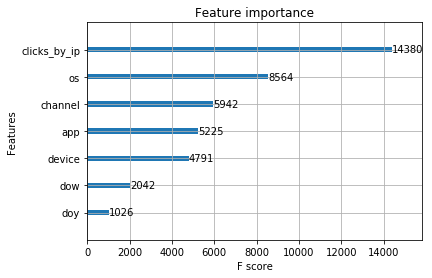

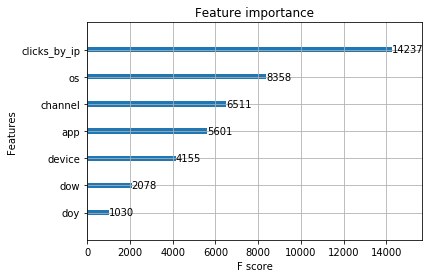

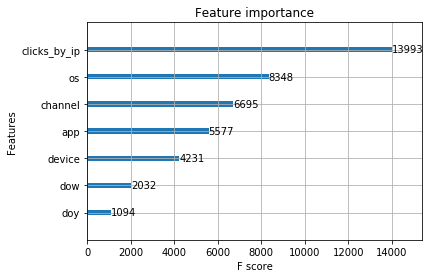

In [5]:
subfilenames = []
for i in range(0, 3):
    subfilenames.append(splXgb(i))
    
subfilenames

In [8]:
from copy import deepcopy
from sklearn import linear_model
from sklearn import metrics
from scipy.special import expit, logit

start_time = time.time()
train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }
nDimSample = 61600000

# Read the last lines because they are more impacting in training than the starting lines
lines = 184903891
skiplines = np.random.choice(np.arange(1, lines), size=lines-1-nDimSample, replace=False)
train = pd.read_csv(path+"train.csv", skiprows=skiplines, nrows=nDimSample, usecols=train_columns, dtype=dtypes)
test = pd.read_csv(path+"test_supplement.csv", usecols=test_columns, dtype=dtypes)
print('[{}] Finished to load data'.format(time.time() - start_time))

# Drop the IP and the columns from target
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)

# Drop IP and ID from test rows
test.drop(['click_id'], axis=1, inplace=True)
gc.collect()

nrow_train = train.shape[0]
merge = pd.concat([train, test])
del train, test
gc.collect()

# Count the number of clicks by ip
ip_count = merge.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']
merge = pd.merge(merge, ip_count, on='ip', how='left', sort=False)
merge['clicks_by_ip'] = merge['clicks_by_ip'].astype('uint16')
merge.drop('ip', axis=1, inplace=True)
train = merge[:nrow_train]
test = merge[nrow_train:]

del test, merge
gc.collect()

print('[{}] Start to generate inputs'.format(time.time() - start_time))
train = timeFeatures(train)
gc.collect()

# predict with xgbs
dtraintest = xgb.DMatrix(train)
del train
gc.collect()

modelfiles = ['../model/splxgbmodel0_2018_0413_1254_31.model', '../model/splxgbmodel1_2018_0413_1307_59.model', '../model/splxgbmodel2_2018_0413_1322_45.model']
count = 0
tag = 'input_'
input = pd.DataFrame()
for modelfile in modelfiles:
    model = xgb.Booster({'nthread':4})
    model.load_model(modelfile)
    pred = model.predict(dtraintest)
    input[tag + str(count)] = pred
    count += 1
del dtraintest, model
gc.collect()

almostzero = 1e-10
almostone = 1 - almostzero
input = input.clip(almostzero, almostone).apply(logit)

print('[{}] Fit stacked logistic regressor'.format(time.time() - start_time))
# fit the train dataset
clf = linear_model.LogisticRegression()
clf.fit(input, y)


print('[{}] Make subs'.format(time.time() - start_time))
# Load the test for predict 
test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)
test = pd.merge(test, ip_count, on='ip', how='left', sort=False)
del ip_count
gc.collect()

sub = pd.DataFrame()
sub['click_id'] = test['click_id'].astype('int')

test['clicks_by_ip'] = test['clicks_by_ip'].astype('uint16')
test = timeFeatures(test)
test.drop(['click_id', 'ip'], axis=1, inplace=True)
dtest = xgb.DMatrix(test)
del test
gc.collect()

count = 0
output = pd.DataFrame()
for modelfile in modelfiles:
    model = xgb.Booster({'nthread':4})
    model.load_model(modelfile)
    pred = model.predict(dtest)
    output[tag + str(count)] = pred
    count += 1

output = output.clip(almostzero, almostone).apply(logit)
from datetime import datetime as dt
datetime = dt.now().strftime('_%Y_%m%d_%H%M_%S')
sub['is_attributed'] = clf.predict_proba(output)[:, 1]
subname = subpath + 'stackxgbLogr_sub' + datetime + '.csv'
sub.to_csv(subname, float_format='%.8f', index=False)

print('[{}] Finished'.format(time.time() - start_time))

[125.52982997894287] Finished to load data
[179.73180317878723] Start to generate inputs
[414.6040892601013] Fit stacked logistic regressor
[517.6745326519012] Make subs
[666.5537819862366] Finished
